<a href="https://colab.research.google.com/github/DLOHai/DLQA_Torch/blob/master/rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recurrent Neural Network: Neural Weather Forecaster

이번 실습의 목표는 다음과 같습니다.
- RNN을 설계하여 지난 며칠 동안의 날씨 정보를 기반으로 24시간 이후의 기온을 예측한다.
- 다양한 속성의 시계열 정보를 활용하기 위해 적절한 전처리 과정을 적용한다. 
- 설계한 모델의 성능을 검증하기 위해 베이스라인 모델을 도입한다.

실습코드는 Python 3.6, Pytorch 1.0 버전을 기준으로 작성되었습니다.

**본문 중간중간에 Pytorch 함수들에 대해 [Pytorch API 문서](https://pytorch.org/docs/stable/) 링크를 걸어두었습니다. API 문서를 직접 확인하는 일에 익숙해지면 나중에 여러분이 처음부터 모델을 직접 구현해야 할 때 정말 큰 도움이 됩니다.**

## 1. Package load
필요한 패키지들을 로드합니다.

In [0]:
import os
import glob
import csv
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data as data
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader


In [0]:
!unzip /content/rnn.zip

Archive:  /content/rnn.zip
replace check_util/__pycache__/checker.cpython-36.pyc? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [0]:
from check_util import checker

## 2. 하이퍼파라미터 세팅
학습에 필요한 하이퍼파리미터의 값을 초기화해줍니다.

미니배치의 크기, 학습할 Epoch(세대) 수, Learning rate(학습률) 값들을 다음과 같이 정합니다. 

In [0]:
batch_size = 100
num_epochs = 30
learning_rate = 0.00003

In [0]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## 3. 데이터 전처리 함수 정의

우리는 이번 실습에서 지난 10년간의(2009년~2018년) 서울시 기후 데이터를 활용해 기온을 예측하는 모델을 학습시킬 것입니다. 데이터셋은 [기상자료개방포털](https://data.kma.go.kr/)에서 받은 자료입니다. 이번 실습에서 사용하는 데이터 이외에도 기상자료개방포털에서 기상과 관련된 다양한 자료들을 내려받으실 수 있습니다. 

'./data/climate_seoul' 경로의 디렉토리를 보시면, test / train / val 디렉토리에 csv파일이 각각 1개 / 8개/ 1개 담겨있음을 확인하실 수 있습니다. 각 csv파일은 1년간의 서울시 기후 데이터를 담고 있으며, 1시간 간격으로 기록된 정보입니다. (사실 아주 가끔씩 30분 간격으로 기록한 구간도 있기도 하지만, 이후 본문에서는 편의상 모두 1시간 간격으로 기록된 것으로 간주하겠습니다.) 매 시간마다 기록되는 정보는 기온, 강수량, 풍속 등을 포함한 총 25가지 속성으로 이루어져 있습니다. 이 중에서 우리는 기온, 강수량, 풍속, 습도, 증기압을 포함한 총 9가지의 속성만을 사용하여 기온 예측 모델을 학습시켜 보겠습니다.

그렇다면 왜 하필 이 9가지의 속성을 선택한 것일까요? 이렇게 9가지의 속성을 선택한 배경에는 어떠한 전문적인 지식도 고려되지 않은 것입니다. 25가지의 속성을 모두 사용해볼 수도 있겠죠. 어떤 속성들을 활용할지는 설계자의 몫입니다. 그런데 여러분이 기상과 관련된 전문적인 지식을 갖고 있지 않는 이상 이중에서 어떤 속성이 기온 예측에 가장 중요한지, 또는 어떤 속성이 가장 불필요한 속성인지 알지 못할 것입니다. 하지만 고맙게도 딥러닝은 이러한 속성 선택 문제에 덜 예민한 학습 방식입니다. 더 정확하게 말하면, 다소 불필요한 정보가 입력으로 주어진다고 해서 극단적으로 학습이 이루어지지 않는 일은 일어나지 않을 가능성이 큽니다. 학습과정에서 인공신경망이 필요한 특징(feature)을 알아서 추출하기 때문입니다. 그러니까 우리는 어떤 속성을 활용할지를 너무 심각하게 고민하지 않아도 되는 것입니다. 다만 이번 실습에서는 매번 빠짐없이 잘 기록된 속성들을 위주로 9가지를 선택한 것 뿐입니다.

아래에 정의한 **preprocess** 메소드는 csv파일들을 읽어 9가지 속성 정보만을 numpy 배열에 저장해 반환하는 역할을 합니다. 이 메소드는 이후에 구현할 Dataset class에서 활용할 것입니다.

In [0]:
def preprocess(all_files):
    data_0 = [] # 기온
    data_1 = [] # 강수량
    data_2 = [] # 풍속
    data_3 = [] # 습도
    data_4 = [] # 증기압
    data_5 = [] # 이슬점 온도
    data_6 = [] # 현지 기압
    data_7 = [] # 해면 기압
    data_8 = [] # 지면 온도
    for f in all_files:
        with open(f, encoding='euc-kr') as c:
            csv_reader = csv.reader(c, delimiter=',')
            header = True
            for col in csv_reader:
                if header:
                    header = False
                    continue
                data_0.append(float(col[2])) if col[2] != '' else data_0.append(0.0)
                data_1.append(float(col[3])) if col[3] != '' else data_1.append(0.0)
                data_2.append(float(col[4])) if col[4] != '' else data_2.append(0.0)
                data_3.append(float(col[6])) if col[6] != '' else data_3.append(0.0)
                data_4.append(float(col[7])) if col[7] != '' else data_4.append(0.0)
                data_5.append(float(col[8])) if col[8] != '' else data_5.append(0.0)
                data_6.append(float(col[9])) if col[9] != '' else data_6.append(0.0)
                data_7.append(float(col[10])) if col[10] != '' else data_7.append(0.0)
                data_8.append(float(col[22])) if col[22] != '' else data_8.append(0.0)

    data = np.zeros((len(data_0), 9))
    for i, d in enumerate(data):
        data[i, 0] = data_0[i]
        data[i, 1] = data_1[i]
        data[i, 2] = data_2[i]
        data[i, 3] = data_3[i]
        data[i, 4] = data_4[i]
        data[i, 5] = data_5[i]
        data[i, 6] = data_6[i]
        data[i, 7] = data_7[i]
        data[i, 8] = data_8[i]
    return data

## 4. Dataset 정의 및 DataLoader 할당

이제 우리가 사용할 데이터셋에 대해 정의할 차례입니다. Pytorch 의 Dataset과 DataLoader에 대해 잘 기억나지 않는다면 ['Lab-04-2'](https://www.youtube.com/watch?v=B3VG-TeO9Lk&list=PLQ28Nx3M4JrhkqBVIXg-i5_CVVoS1UzAv&index=8&t=0s) 강의를 참고하시기 바랍니다.

생성자(**\__init__**)는 미리 구현을 해두었습니다. 여기서 사용되는 각 변수의 의미는 다음과 같습니다.
- **seq_len**: 우리가 이후에 설계할 RNN의 입력으로 줄 데이터 시퀀스의 길이, 즉 총 타임스텝의 길이를 뜻합니다. 다시 말하면, 현재로부터 24시간 뒤의 기온을 예측하기 위해 얼마만큼의 과거 정보를 참고할지 결정하는 것입니다. 기본값을 480로 해두었는데, 이는 480개의 과거 데이터를 살펴보겠다는 것이고, 데이터 1개는 1시간마다 기록되기 때문에 결과적으로 지난 20일간의 데이터를 기반으로 24시간 후의 기온을 예측하겠다는 의미입니다. 
- **target_delay**: 우리가 예측할 시점이 입력 시퀀스의 마지막 타임스텝으로 얼만큼 이후인지 결정하는 것입니다. 24로 기본값을 해두었고, 이는 24시간 이후의 기온이 우리가 예측할 대상임을 의미하는 것입니다. 
- **stride**: 데이터를 모델에게 입력으로 주기 위해 우리는 **seq_len** 길이 만큼의 정보를 우리가 가진 전체 데이터에서 임의로 선택해야 합니다. 임의로 선택된 그 시작 지점을 시작 인덱스라고 부른다면, **stride**는 그 시작 인덱스 후보들 간의 간격을 의미합니다. **stride=1**이라면 모든 시점의 데이터가 시작 인덱스가 될 수 있는 것이고, **stride=2**이면 아래의 그림처럼 시작 인덱스 후보가 하나씩 건너띄어 존재하므로, 전체 데이터 포인트에서 절반만이 시작 인덱스가 될 수 있습니다. **stride**가 작을수록 모델의 서로다른 입력간에 정보가 중복되는 정도가 크겠죠. (**stride=1**을 '01234', '12345', '23456' 이라고 생각하고 **stride=2**를 '01234', '23456', '45678' 이라고 생각하면 이해가 되실 겁니다.) 어떤 값으로 정할지는 역시 설계자인 우리의 몫입니다. 이번 예제에서는 기본값을 5로 정하겠습니다.
<img src="./img/stride.png" width="80%" height="60%">
- **all_files**: 정의할 Dataset에 사용할 모든 csv파일의 경로를 담고 있습니다. **data_dir**은 데이터셋의 디렉토리 경로를 의미하고 **mode**는 정의하고자 하는 Dataset에 따라 'train' 또는 'val' 또는 'test'으로 구분될 것입니다. 
- **self.data**: 위에서 정의한 데이터 전처리 메소드인 **preprocess**에서 데이터를 전처리한 결과가 저장됩니다. **self.data**의 shape은 (데이터의 총 길이, 9)가 됩니다.
- **normalize**: 입력으로 사용하는 데이터의 각 속성은 저마다 값의 범위가 다릅니다. 예를들어 기온은 보통 -15에서 35사이의 값을 갖지만, 강수량과 풍속은 음수 값이 존재하지 않고, 기압의 경우에는 1000 내외의 값이 일반적입니다. 이러한 경우 각각의 속성들을 저마다의 평균과 표준편차를 통해 값을 정규화해주는 것이 바람직합니다. 

이제 다음을 읽고 코드를 완성해보세요.
- **\__len__**은 미리 구현을 해두었고, 이제 여러분이 직접 **\__getitem__**을 구현해야 합니다. 모델의 입력으로 줄 데이터 시퀀스를 **sequence** 변수에 저장하고, 그 **sequence**의 가장 마지막 타임스텝으로부터 24시간 후의 기온을 **target** 변수에 저장하여 코드를 완성해보세요.
- **sequence**의 shape은 (**seq_len**, 9)가 되어야 합니다. **index**는 **\__len__**에서 정의한 데이터의 총 길이를 값의 범위로 합니다. 예를 들어 현재 가진 데이터셋의 총 길이와 주어진 **seq_len**, **stride**를 고려했을 때 존재할 수 있는 시작 인덱스 후보가 1000개라면 **\__len__**는 1000을 반환할 것이고 **index**는 0~999 사이의 값을 가지게 됩니다. 
- **target**의 shape은 (1)이 되어야 합니다. 
- **힌트**: **sequence**를 정의하기 위해서는 아마 우리가 가진 전체 데이터, 즉 **self.data**에서 시작 인덱스부터 **seq_len** 길이만큼을 인덱싱을 해서 가져와야 할 것입니다. 이때 시작 인덱스로 **index**를 곧장 사용해서는 안됩니다. 앞서 언급한 것처럼 **index**는 0과 시작 인덱스 후보의 총 갯수 사이의 값이지, 그 자체로 시작 인덱스를 의미하는 것이 아닙니다. 시작 인덱스를 구하기 위해서는 **index**에 **self.stride**를 곱해주어야 합니다.


In [0]:
class Dataset(data.Dataset):
    def __init__(self, data_dir, mode, seq_len=480, target_delay=24, stride=5, normalize=True):
        self.seq_len = seq_len
        self.target_delay = target_delay
        self.stride = stride
        all_files = glob.glob(os.path.join(data_dir, mode, '*'))
        self.data = preprocess(all_files)
        if normalize:
            mean = self.data.mean(axis=0)
            std = self.data.std(axis=0)
            self.data = (self.data - mean) / std
    
    def __getitem__(self, index):
        # 코드 시작
        index *= self.stride
        sequence = self.data[index:index + self.seq_len, :]
        target = self.data[index + self.seq_len + self.target_delay - 1]
        target = target[0]
        target = np.expand_dims(target, 0)
        # 코드 종료
        return sequence, target
    
    def __len__(self):
        max_idx = len(self.data) - self.seq_len - self.target_delay
        num_of_idx = max_idx // self.stride
        return num_of_idx

이제 학습용, 검증용, 테스트용 Dataset과 DataLoader를 각각 할당합니다. 

In [0]:
data_dir = './data/climate_seoul'
train_data = Dataset(data_dir, 'train')
val_data = Dataset(data_dir, 'val')
test_data = Dataset(data_dir, 'test')

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, drop_last=True)

아래의 코드를 실행해 코드를 성공적으로 완성했는지 확인해보세요. 

별다른 문제가 없다면 이어서 진행하면 됩니다.

In [0]:
checker.customized_dataset_check(train_data.seq_len, train_data)

__getitem__ 함수가 반환하는 target이 24시간 후의 기온이 아닙니다. 인덱싱을 올바르게 했는지 다시 확인하시기 바랍니다.
__getitem__ 함수가 반환하는 sequence가 self.data로부터 올바르게 인덱싱되고 있지 않습니다. stride를 고려하여 시작 인덱스를 올바르게 구했는지 다시 확인하시기 바랍니다.


## 5. 데이터 샘플 시각화

**train_data**의 첫번째 **sequence**를 그래프 형태로 시각화합니다. 

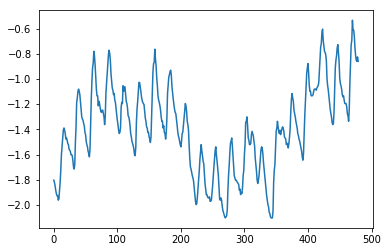

In [0]:
temp = train_data[0][0]
temp = temp[:, 0]
plt.plot(range(len(temp)), temp)
plt.show()

## 6. 베이스라인 성능 측정

이후에 우리가 학습시킨 모델의 성능의 좋고 나쁨을 판단할 기준(베이스라인)이 필요합니다. 적당한 수준의 기준 성능을 정해놓고 테스트 결과에서 우리의 모델이 그것보다 더 좋은 성능을 보이면 만족할만한 모델을 학습시킨 것으로 간주하면 되고, 반대로 그보다 성능이 좋지 않다면 모델을 더 개선시키는 방식으로 네트워크 구조를 변경해 나아가면 됩니다.

과거의 기후 정보를 활용하는 우리의 딥러닝 모델이 과연 의미있는 성능이라는 걸 보이기 위해서는 어떠한 예측 방식이 기준이 될 수 있을까요? 아마 기온 예측 전문가가 아닌 대부분의 여러분이 지금으로부터 24시간 후의 기온을 예측하라는 질문을 받았다고 생각해 봅시다. 아마 가장 무난하면서도 안정적으로 예측하는 방식은 지금의 기온과 같다고 답하는 것일 겁니다. 이러한 예측 방식은 과거의 기후 정보를 복잡하게 고려할 필요도 없이 간단하지만, 많은 경우에 실제로 꽤나 정확한 예측을 할 수 있는 방식입니다. 내일 낮 12시의 기온은 특이한 경우가 아니라면, 오늘 낮 12시의 기온과 거의 비슷할 것입니다. 

아래의 **eval_baseline**은 이런 예측 방식의 성능, 즉 평균적인 loss를 측정하는 메소드입니다. 다음을 읽고 코드를 완성해보세요.
- 우리의 베이스라인은 현재 기온을 24시간 후의 기온으로 예측하는 방식입니다. 현재 기후 정보는 **data_loader**에서 받은 **sequence**의 가장 마지막 타임스텝에 담겨있습니다. 입력으로 주는 **sequence**는 기온 뿐만아니라 총 9가지 속성이 포함된 것임에 유의하세요. 기온은 9가지 속성중 가장 첫번째에 위치하고 있음을 염두에 두고 **sequence**로 부터 현재 기온을 가져와 **pred** 변수에 저장하세요.
- **pred**의 shape은 (batch_size, 1)이 되어야 합니다. 만약 여러분이 구한 **pred**의 shape이 (batch_size)라면, [torch.unsqueeze](https://pytorch.org/docs/stable/torch.html#torch.unsqueeze)를 활용하여 크기 1인 차원을 텐서에 삽입해보세요. 
- **criterion**이 우리가 선언한 loss function일 때, loss를 계산하여 **loss** 변수에 저장하세요. 

In [0]:
def eval_baseline(data_loader, criterion):
    total_loss = 0
    cnt = 0
    for step, (sequence, target) in enumerate(data_loader):
        # 코드 시작
        loss = criterion(pred, target)
        # 코드 종료
        total_loss += loss
        cnt += 1
    avrg_loss = total_loss / cnt
    print('Baseline Average Loss: {:.4f}'.format(avrg_loss))
    return avrg_loss.item()

베이스라인의 성능을 측정합니다. 다음과 같은 결과가 출력된다면 성공적으로 구현한 것입니다.

Baseline Average Loss: 0.0945

In [0]:
baseline_loss = eval_baseline(test_loader, nn.MSELoss())

Baseline Average Loss: 0.0945


## 7. 네트워크 설계

우리는 LSTM 구조를 통해 기온 예측을 모델을 학습시킬 것입니다. 설계할 네트워크의 대략적인 개요는 아래 그림과 같습니다.

<img src="./img/lstm.png" width="80%" height="60%">

LSTM의 매 타임스텝의 입력은 매 시간마다 기록된 9가지 속성값이 들어가게 됩니다. 그리고 마지막 타입스텝의 출력을 마무리로 Fully Connected 레이어에 넣어 최종 예측 기온값을 출력하는 구조입니다.  

다음을 읽고 코드를 완성해보세요.
- 생성자의 파라미터 **hidden_size**는 우리가 설계할 LSTM 레이어의 hidden state의 크기입니다. 이 크기를 얼마를 할지는 역시 설계자의 몫입니다. 이번 예제에서 기본값은 100으로 하겠습니다. 
- **num_layers**는 LSTM 레이어의 총 레이어 수입니다. 기본값은 1로 하겠습니다.
- [nn.LSTM](https://pytorch.org/docs/stable/nn.html#torch.nn.LSTM)을 활용하여 생성자에 LSTM 레이어를 선언하고 이를 **self.lstm** 변수에 저장하세요. LSTM 레이어 선언에 필요한 파라미터인 **input_size**에 적절한 값을 넣어보세요. 또 다른 파라미터인 **hidden_size**, **num_layers**에는 각각 **self.hidden_size**, **self.num_layers**를 넣어주세요. 그리고 **batch_first=True**로 하시기 바랍니다. **batch_first=True**이면 LSTM 레이어의 입력의 shape이 (**batch_size**, 전체 시퀀스 길이, **input_size**)가 됩니다. 기본값은 **batch_first=False**인데, 이 경우 (전체 시퀀스 길이, **batch_size**, **input_size**)가 됩니다. 
- LSTM의 마지막 타임스텝의 출력을 입력으로 받아 최종 기온을 예측하는 FC 레이어를 선언하고 이를 **self.fc** 변수에 저장하세요. 
- **forward** 함수를 구현할 차례입니다. **forward**의 파라미터 **x**, **h**, **c**는 각각 LSTM의 입력, LSTM의 초기 hidden state, 초기 cell state를 의미합니다. Pytorch의 LSTM 레이어는 **x, (h, c)**를 입력으로 주면 **LSTM의 모든 타입스텝의 출력, (마지막 타임스텝의 hidden state, 마지막 타임스텝의 cell state)**를 반환합니다. (hidden state와 cell state을 입출력으로 주고 받을 때에는 둘을 괄호로 묶어 tuple 형태여야 함에 유의하시기 바랍니다.)
- LSTM의 출력의 마지막 타임스텝의 출력을 FC 레이어에 입력으로 주어 얻은 결과를 **final_output** 변수에 저장하세요.
- 마지막으로 **init_hidden** 함수를 구현할 차례입니다. **init_hidden**은 초기 hidden state, cell state를 만들어 반환하는 함수입니다. 초기 hidden state, cell state는 일반적으로 0으로 채운 값을 사용합니다. 0으로 채운 텐서를 생성하기 위해서는 [torch.zeros](https://pytorch.org/docs/stable/torch.html?highlight=zeros#torch.zeros)를 활용하시기 바랍니다. hidden state와 cell state의 shape은 (**num_layers**, **batch_size**, **hidden_size**)가 되어야 합니다. 0으로 채운 hidden state와 cell state를 선언하여 각각 **hidden**, **cell** 변수에 저장하세요. 

In [0]:
class SimpleLSTM(nn.Module):
    def __init__(self, hidden_size=100, num_layers=1):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        # 코드 시작
        self.lstm = nn.LSTM(input_size=9, hidden_size=hidden_size, num_layers=num_layers, batch_first=True).to(device)
        self.fc = nn.Linear(in_features=hidden_size, out_features=1).to(device)
        # 코드 종료
    
    def forward(self, x, h, c):
        # 코드 시작
        out, (h, c) = self.lstm(x, (h, c))
        last_out = out[:, -1, :]
        final_output = self.fc(last_out)
        # 코드 종료
        return final_output
    
    def init_hidden(self):
        # 코드 시작
        hidden = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
        cell = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
        # 코드 종료
        return hidden, cell

아래의 코드를 실행해 코드를 성공적으로 완성했는지 확인해보세요. 

별다른 문제가 없다면 이어서 진행하면 됩니다.

In [0]:
checker.model_check(SimpleLSTM(), batch_size)

체크 함수를 실행하는 도중에 문제가 발생했습니다. 코드 구현을 완료했는지 다시 검토하시기 바랍니다.


## 8. train, validation, test 함수 정의

이번에는 훈련, 검증, 테스트를 진행하는 함수를 정의하겠습니다.

먼저 훈련 함수입니다. 다음을 읽고 코드를 완성해 보세요.
- 먼저 **sequence**, **target**의 데이터 형식을 **torch.float32**로 변환해주었습니다. 이렇게 해주는 이유는 현재 구현한 DataLoader에서는 **torch.float64** 형식으로 데이터를 반환하는데, 모델의 파라미터는 기본적으로 **torch.float32**로 이루어져 있기 때문입니다. 모델의 파라미터와 입력 텐서가 같은 데이터 형식을 갖도록 해주어야 합니다. Torch.Tensor의 다양한 데이터 형식에 대해 알아보려면 [여기](https://pytorch.org/docs/stable/tensor_attributes.html#torch.torch.dtype)를 참고하시기 바랍니다. 
- 위의 모델에서 구현했던 **init_hidden** 함수를 이용해 초기 hidden state와 cell state를 받아 각각 **h0**, **c0** 변수에 저장합니다.
- **train** 함수에 여러 인자들이 보입니다. **model**이 우리가 선언한 모델일 때, 모델에 입력 시퀀스와, 초기 hidden state, cell state를 주고 얻은 결과를 **outputs**에 저장합니다.
- **criterion**이 우리가 선언한 loss function일 때, **outputs**와 **target**을 통해 loss를 계산하고 그 결과를 **loss**에 저장합니다.
- **optim**이 우리가 선언한 optimizer일 때, 이전에 계산한 기울기를 모두 clear하고, backpropagation을 통해 기울기를 계산하고, optimizer를 통해 파라미터를 업데이트합니다. 

**tarin**에서는 일정한 에폭마다 다음에 구현할 **validation**함수를 통해 검증을 수행합니다. 모델 검증을 수행했을 때, 만약 검증 과정의 평균 loss가 현재까지 가장 낮다면 가장 잘 훈련된 모델로 가정하고 그때까지 학습한 모델을 저장합니다. 저장은 추후에 구현할 **save_model** 함수가 수행합니다. 

In [0]:
def train(num_epochs, model, data_loader, criterion, optim, saved_dir, val_every):
    print('Start training..')
    best_loss = 9999999
    for epoch in range(num_epochs):
        for step, (sequence, target) in enumerate(data_loader):
            sequence = sequence.to(device, torch.float32)
            target = target.to(device, torch.float32)
            # 코드 시작
            h0, c0 = model.init_hidden()
            h0.to(device)
            c0.to(device)
            outputs = model(sequence, h0, c0).to(device)
            loss = criterion(outputs, target).to(device)
            
            optim.zero_grad()
            loss.backward()
            optimizer.step()
            # 코드 종료
            
            if (step + 1) % 1 == 0:
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(
                    epoch+1, num_epochs, step+1, len(train_loader), loss.item()))
                
        if (epoch + 1) % val_every == 0:
            avrg_loss = validation(epoch + 1, model, val_loader, criterion)
            if avrg_loss < best_loss:
                print('Best performance at epoch: {}'.format(epoch + 1))
                print('Save model in', saved_dir)
                best_loss = avrg_loss
                save_model(model, saved_dir)

검증 함수입니다. 다음을 읽고 코드를 완성해보세요.
- 검증 과정에서는 파라미터 업데이트를 하지 않기 때문에 기울기를 계산할 필요는 없습니다. 하지만 검증 과정에서의 평균 loss를 계산하기 위해 loss는 계산해야 합니다. 
- 먼저 **train** 함수와 마찬가지로 초기 hidden state, cell state를 선언해 **h0**, **c0** 변수에 저장합니다. 그리고 **model**에 입력 시퀀스와 초기 hidden state, cell state를 주어 얻은 결과를 **outputs**에 저장하고, **criterion**을 통해 loss를 계산한 뒤, 그 결과를 **loss**에 저장합니다.

In [0]:
def validation(epoch, model, data_loader, criterion):
    print('Start validation #{}'.format(epoch))
    model.eval()
    with torch.no_grad():
        total_loss = 0
        cnt = 0
        for step, (sequence, target) in enumerate(data_loader):
            sequence = sequence.to(device, torch.float32)
            target = target.to(device, torch.float32)
            # 코드 시작
            h0, c0 = model.init_hidden()
            h0.to(device)
            c0.to(device)
            outputs = model(sequence, h0, c0).to(device)
            loss = criterion(outputs, target).to(device)
            # 코드 종료
            total_loss += loss
            cnt += 1
        avrg_loss = total_loss / cnt
        print('Validation #{}  Average Loss: {:.4f}'.format(epoch, avrg_loss))
    model.train()
    return avrg_loss

테스트 함수입니다. 다음을 읽고 코드를 완성해보세요.

- **validation** 함수와 마찬가지로 초기 hidden state, cell state를 선언해 **h0**, **c0** 변수에 저장합니다. 그리고 **model**에 입력 시퀀스와 초기 hidden state, cell state를 주어 얻은 결과를 **outputs**에 저장하고, **criterion**을 통해 loss를 계산한 뒤, 그 결과를 **loss**에 저장합니다.

In [0]:
def test(model, data_loader, criterion, baseline_loss):
    print('Start test..')
    model.eval()
    with torch.no_grad():
        total_loss = 0
        cnt = 0
        for step, (sequence, target) in enumerate(data_loader):
            sequence = sequence.to(device, torch.float32)
            target = target.to(device, torch.float32)
            # 코드 시작
            h0, c0 = model.init_hidden()
            h0.to(device)
            c0.to(device)
            outputs = model(sequence, h0, c0).to(device)
            loss = criterion(outputs, target).to(device)
            # 코드 종료
            total_loss += loss
            cnt += 1
        avrg_loss = total_loss / cnt
        print('Test  Average Loss: {:.4f}  Baseline Loss: {:.4f}'.format(avrg_loss, baseline_loss))
        
    if avrg_loss < baseline_loss:
        print('베이스라인 성능을 뛰어 넘었습니다!')
    else:
        print('아쉽지만 베이스라인 성능을 넘지 못했습니다.')

## 9. 모델 저장 함수 정의

모델을 저장하는 함수입니다. 모델 저장은 [torch.save](https://pytorch.org/docs/stable/torch.html?highlight=save#torch.save) 함수를 통해 할 수 있습니다. 
[nn.Module.state_dict](https://pytorch.org/docs/stable/nn.html?highlight=state_dict#torch.nn.Module.state_dict)를 통해 Module, 즉 우리 모델의 파라미터를 가져올 수 있습니다. 이렇게 불러온 파라미터를 **check_point** 딕셔너리에 저장합니다. 그리고 이 **check_point**를 정해준 경로에 저장하면 됩니다. 

torch.save는 단순히 모델의 파라미터만 저장하는 함수가 아닙니다. 어떤 파이썬 객체든 저장할 수 있습니다. 그래서 경우에 따라 **check_point** 딕셔너리에 모델의 파라미터 뿐만 아니라 다른 여러 가지 필요한 정보를 저장할 수도 있습니다. 예를 들어 총 몇 에폭동안 학습한 모델인지 그 정보도 저장할 수 있겠죠? 

다음을 읽고 코드를 완성해보세요.
- torch.save를 통해 **output_path** 경로에 **check_point**를 저장하세요.

In [0]:
def save_model(model, saved_dir, file_name='best_model.pt'):
    os.makedirs(saved_dir, exist_ok=True)
    check_point = {
        'net': model.state_dict()
    }
    output_path = os.path.join(saved_dir, file_name)
    # 코드 시작
    torch.save(check_point, output_path)
    # 코드 종료

## 10. 모델 생성 및 Loss function, Optimizer 정의

이제 학습할 모델을 생성하고 loss function과 optimizer를 정의할 차례입니다. 다음을 읽고 코드를 완성해보세요.
- 위에서 정의한 SimpleLSTM class를 통해 모델을 생성하고 이를 **model** 변수에 저장합니다.
- 연속된 값을 예측하는 회기(regression) 문제에서는 보통 Mean Squared Error(MSE) loss function을 사용합니다. [nn.MSELoss](https://pytorch.org/docs/stable/nn.html?highlight=mseloss#torch.nn.MSELoss)를 통해 MSE loss function을 선언하고 이를 **criterion** 변수에 저장합니다.
- Adam optimizer를 통해 파라미터를 업데이트 하겠습니다. Adam optimizer([torch.optim.Adam](https://pytorch.org/docs/stable/optim.html?highlight=adam#torch.optim.Adam))를 **optimizer** 변수에 저장합니다.

**val_every**는 검증을 몇 에폭마다 진행할지 정하는 변수입니다. **saved_dir**은 모델이 저장될 디렉토리의 경로입니다. 

In [0]:
# 코드 시작
model = SimpleLSTM().to(device)
criterion = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# 코드 종료
val_every = 1
saved_dir = './saved/LSTM'

아래의 코드를 실행해 코드를 성공적으로 완성했는지 확인해보세요. 

별다른 문제가 없다면 이어서 진행하면 됩니다.

In [0]:
checker.loss_func_check(criterion)
checker.optim_check(optimizer)

MSE loss function을 잘 정의하셨습니다! 이어서 진행하셔도 좋습니다.
Adam optimizer를 잘 정의하셨습니다! 이어서 진행하셔도 좋습니다.


## 11. Training

**train** 함수를 통해 모델 학습을 진행합니다. LSTM과 같은 recurrent layer는 타임스텝을 따라 계산이 순차적으로 진행을 해야 되기 때문에 상대적으로 학습 시간이 많이 소요됩니다. 따라서 시간이 여유가 없는 분들은 모델 학습이 적당히 진행된다는 정도만 확인하고 다음 단계로 넘어가셔도 됩니다.

만약 한 에폭 이상이 지나도록 loss가 전혀 감소하는 기미가 보이지 않는다면 이전의 구현에 문제가 있을 가능성이 높으니 코드를 다시 검토해주시기 바랍니다.

또한, 모델 저장 코드를 제대로 구현했다면 첫 에폭 학습후에 ./saved/LSTM 경로에 best_model.pt 파일이 저장되어 있어야 합니다. 만약에 파일이 존재하지 않는다면 모델 저장 코드를 다시 확인하시기 바랍니다.

In [0]:
train(num_epochs, model, train_loader, criterion, optimizer, saved_dir, val_every)

Start training..
Epoch [1/30], Step [1/139], Loss: 1.0675
Epoch [1/30], Step [2/139], Loss: 1.0593
Epoch [1/30], Step [3/139], Loss: 0.8684
Epoch [1/30], Step [4/139], Loss: 1.0954
Epoch [1/30], Step [5/139], Loss: 1.1162
Epoch [1/30], Step [6/139], Loss: 1.0491
Epoch [1/30], Step [7/139], Loss: 1.2158
Epoch [1/30], Step [8/139], Loss: 0.9393
Epoch [1/30], Step [9/139], Loss: 0.8996
Epoch [1/30], Step [10/139], Loss: 0.9082
Epoch [1/30], Step [11/139], Loss: 0.8983
Epoch [1/30], Step [12/139], Loss: 1.0149
Epoch [1/30], Step [13/139], Loss: 1.0637
Epoch [1/30], Step [14/139], Loss: 1.0560
Epoch [1/30], Step [15/139], Loss: 0.9612
Epoch [1/30], Step [16/139], Loss: 0.9994
Epoch [1/30], Step [17/139], Loss: 0.9839
Epoch [1/30], Step [18/139], Loss: 0.8016
Epoch [1/30], Step [19/139], Loss: 1.0151
Epoch [1/30], Step [20/139], Loss: 0.9264
Epoch [1/30], Step [21/139], Loss: 0.9161
Epoch [1/30], Step [22/139], Loss: 1.0179
Epoch [1/30], Step [23/139], Loss: 1.1032
Epoch [1/30], Step [24/139

## 12. 저장된 모델 불러오기 및 test

학습한 모델의 성능을 테스트합니다. 저장한 모델 파일을 [torch.load](https://pytorch.org/docs/stable/torch.html?highlight=load#torch.load)를 통해 불러옵니다. 위에서 학습을 끝까지 진행하지 않았다면, 아래의 주석 처리된 부분을 주석 해제하면, 제공해드린 미리 학습시킨 모델을 불러올 수 있습니다. 

이렇게 불러오면 우리가 얻게 되는 건 아까 저장한 **check_point** 딕셔너리입니다. 딕셔너리에 저장한 모델의 파라미터는 **'net'** key에 저장해두었습니다. 이를 불러와 **state_dict**에 저장합니다. 이렇게 불러온 모델의 파라미터를 모델에 실제로 로드하기 위해서는 [nn.Module.load_state_dict](https://pytorch.org/docs/stable/torch.html?highlight=load#torch.load)를 사용하면 됩니다. 

다음을 읽고 코드를 완성해보세요.
- **model_path**의 경로에 있는 모델 파일을 로드하여, 이를 **check_point** 변수에 저장합니다. 
- **check_point** 딕셔너리에 접근하여 모델의 파라미터를 **state_dict** 변수에 저장합니다.
- **state_dict**의 파라미터들을 우리 모델에 로드합니다.

In [0]:
model_path = './saved/LSTM/best_model.pt'
# model_path = './saved/pretrained/LSTM/best_model.pt' # 모델 학습을 끝까지 진행하지 않은 경우에 사용
model = SimpleLSTM() # 아래의 모델 불러오기를 정확히 구현했는지 확인하기 위해 새로 모델을 선언하여 학습 이전 상태로 초기화
# 코드 시작
checkpoint = torch.load(model_path)
state_dict = checkpoint['net']
model.load_state_dict(state_dict)
# 코드 종료

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

마지막으로 모델의 성능을 테스트합니다. 베이스라인 성능을 뛰어 넘었다는 문구가 나오면 성공적으로 진행한 것입니다. 

In [0]:
test(model, test_loader, criterion, baseline_loss)

Start test..
Test  Average Loss: 0.0889  Baseline Loss: 0.0945
베이스라인 성능을 뛰어 넘었습니다!
